In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator # for minor ticks
from matplotlib import gridspec

import numpy as np
import pandas as pd

import scipy.io as sio

from itertools import product

import sys
sys.path.append("../..")

from neuroprob import stats, tools, neural_utils
import neuroprob.models as mdl

dev = tools.PyTorch()

../..\neuroprob\models\parametrics.py:388: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if inner_var is not 0:
../..\neuroprob\models\parametrics.py:447: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if inner_var is not 0:
../..\neuroprob\models\nonparametrics.py:270: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  kernel = kernels.Product(kernel, krn) if kernel is not 0 else krn
../..\neuroprob\models\nonparametrics.py:340: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  kernel = kernels.Product(kernel, krn) if kernel is not 0 else krn
../..\neuroprob\models\likelihoods.py:901: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if inner_var is not 0: # MC samples


PyTorch version: 1.6.0
Using device: cpu


This notebook contains code for:
- Toy model of 1D phase precession to generate synthetic data
- Performing the 'Huxter' test for independent rate and temporal coding
- Brown paper no coupling, Huxter test
- Brown paper with coupling, Huxter test

**When saving figures, first navigate to the appropriate folder**

In [2]:
import os
os.getcwd()

'C:\\Users\\Mattijs\\Documents\\Mattijs\\Engineering IIB\\Thesis\\neural-data-analysis\\notebook\\CA_precession'

In [5]:
os.chdir('..')

In [6]:
os.getcwd()

'C:\\Users\\Mattijs\\Documents\\Mattijs\\Engineering IIB\\Thesis\\neural-data-analysis'

### Synthetic one-dimensional phase precession model
Chadwick, Angus, Mark CW van Rossum, and Matthew F. Nolan `Independent theta phase coding accounts for CA1 population sequences and enables flexible remapping.` Elife 4 (2015): e03542.

\begin{align}
r_x(x) &= r_0\exp\Big(\frac{(x-c)}{2\sigma^2}\Big)  \\
r_\theta(\theta(t), \theta_0(x)) &= \exp\big(\beta \cos(\theta(t) - \theta_0(x))\big)\\
\theta_0(x) &= 2\pi\Big(1-\frac{(x-c+R)}{2R}\Big) - \pi\\
\theta(t) &= 
\end{align}

<strong>Extension:</strong> Use 2D form, see appendix A6

In [2]:
# phase precession model
def gen_field(x, theta, cen, sigma):
    # Requires theta -pi, +pi
    beta = 1.0 # 1.5
    c = np.array([cen])
    rate_0 = 10
    R = 2*sigma
    theta_0 = 2*np.pi * (1 - (np.clip(x, c-R, c+R)-c+R)/2/R) - np.pi
    rate = rate_0*np.exp(-0.5*((x-c)/sigma)**2) * np.exp(beta*np.cos(theta - theta_0))
    return rate


def gen_theta_t(theta_period, theta_offset, dt, sim_samples):
    theta_t = np.zeros(sim_samples)
    theta_t.fill(2*np.pi / (theta_period/dt)) # radians
    theta_t = np.cumsum(theta_t) + theta_offset
    theta_t = theta_t % (2*np.pi) - np.pi # -pi to +pi
    
    return theta_t

## Toy data fitted on GP

In [9]:
def heatmap_GP(rate_models, x_max, x=None, theta=None, index_spikes=None, true_rate=True):
    funcs = []
    ax_title = {}
    
    if len(rate_models) == 1:
        def func_GP(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            theta = pos[1].flatten()
            covariates = [x, theta]
            return rate_models[0].eval_rate(covariates, [neuron])[0].reshape(*prevshape)
        funcs.append(func_GP)
        ax_title[len(funcs) - 1] = "GP"

    if true_rate:
        def func_true(pos, centre=30, sigma=10):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            theta = pos[1].flatten()
            covariates = [x, theta]
            return gen_field(x, theta, centre, sigma).reshape(*prevshape)
        funcs.append(func_true)
        ax_title[len(funcs) - 1] = "True"
    
    nrows = 1
    ncols = len(funcs)
    widths = [0.5] * ncols
    heights = [1] * nrows
    
    fig = plt.figure(figsize=(4*ncols, 3*nrows))

    spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                             height_ratios=heights)#, left=0., right=0.2, bottom=0., top=1.)

    neuron = 0
#     x_max = x_ts.max() # mm
        
    for i, func in enumerate(funcs):
    
        grid_shape = [[0, x_max], [0, 4*np.pi]]
        grid_size = [50, 80]

        ax = fig.add_subplot(spec[0, i])
        _, field = tools.compute_mesh(grid_size, grid_shape, func)
        _, ax = tools.visualize_field(field, grid_shape, ticktitle='firing rate (Hz)', figax=(fig, ax), aspect='auto')

        ylabel = r'$\theta$'
        xlabel = r'$x$ (mm)'
        tools.decorate_ax(ax, xlabel=xlabel, ylabel=ylabel, xlim=[0, np.round(x_max)], ylim=[0, 4*np.pi],
                          xticks=[0, np.round(x_max)], yticks=[0, 2*np.pi, 4*np.pi],
                          spines=[False, False, False, False])
        ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])
        ax.set_title(ax_title[i])
    
        if x is not None:
            ax.plot(x, theta, 'r')
        if index_spikes is not None:
            ax.plot(x[index_spikes], theta[index_spikes], 'kx')

    #plt.savefig('output/GP_likelihoods.svg', bbox_inches='tight')
    #plt.savefig('output/GP_likelihoods.pdf', bbox_inches='tight')
    plt.tight_layout(w_pad=1)
    plt.show()
    
    return fig

In [14]:
def GP_2D(x_ts, theta_ts, spikes, n_runs, x_max, dt, neurons, sim_samples):
    tot_timesteps = sim_samples*n_runs
    
    # kernel
    l_spat = 10.*np.array([np.ones(neurons)])
    l_ang = 1.*np.array([np.ones(neurons)])
    v = np.ones(neurons)
    kernels_tuples = [('variance', v), ('RBF', 'euclid', l_spat), ('RBF', 'torus', l_ang)]
    
    # inducing points
    in_dims = 2
    num_induc = 8
    inducing_points = np.array([np.linspace(0, x_max, num_induc), 
                                np.linspace(0, 2*np.pi, num_induc+1)[:-1]]).T[None, :, :].repeat(neurons, axis=0)
    # repeat to get separate inducing points per neuron

    # GP model
    rate_model = mdl.nonparametrics.Gaussian_process(in_dims, # input dimensions
                                                     neurons, # number of neurons
                                                     kernels_tuples, # kernels
                                                     inducing_points=inducing_points, # initial inducing points
                                                     mean=0.*np.ones((neurons)), # initial GP mean
                                                     learn_mean=True, # learnable mean
                                                     inv_link='exp', # inverse link function
                                                     jitter=1e-3) # jitter (numerical stability)


    # likelihood model
    likelihood = mdl.likelihoods.Poisson(dt, neurons, 'exp') # inverse link function
    likelihood.set_Y(spikes, batch_size=tot_timesteps, filter_len=1)

    # inputs
    covariates = [x_ts.flatten(), utils.signal.WrapPi(theta_ts.flatten(), True)] # 0 to 2*pi
    VI_tuples = [(None, None, None, 1), (None, None, None, 1)] # no latent variables
    inputs = mdl.inference.input_group(in_dims, VI_tuples)
    inputs.set_XZ(covariates, resamples, batch_size=tot_timesteps, filter_len=1)


    # VI framework
    glm = mdl.inference.VI_optimized(inputs, rate_model, likelihood)
    glm.to(dev) # move to GPU if available

    # fitting
    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
    opt_tuple = (optim.Adam, 100, sch)
    opt_lr_dict = {'default': 1e-2}#, 'kernel.lengthscale': 5*1e-3}

    glm.set_optimizers(opt_tuple, opt_lr_dict)

    annealing = lambda x: 1.0#min(1.0, 0.001*x)
    losses = glm.fit(1000, loss_margin=1e0, margin_epochs=100, anneal_func=annealing, 
                     cov_samples=1, ll_samples=10)

#     plt.figure()
#     plt.plot(losses[25:])
#     plt.xlabel('epoch')
#     plt.ylabel('NLL per time sample')
#     plt.show()
    
    return rate_model

In [15]:
def GP_2x1D_prod(x_ts, theta_ts, spikes, n_runs, x_max, dt, neurons, sim_samples):
    tot_timesteps = sim_samples*n_runs
    
    l_spat = 10.*np.array([np.ones(neurons)])
    l_ang = 1.*np.array([np.ones(neurons)])
    v = np.ones(neurons)
    kernels_tuples_list = [
        [('RBF', 'euclid', l_spat)], 
        [('RBF', 'torus', l_ang)]
    ]

    in_dims = 2
    num_induc = 8
    inducing_points = np.array([np.linspace(0, x_max, num_induc), 
                                np.linspace(0, 2*np.pi, num_induc+1)[:-1]]).T[None, :, :].repeat(neurons, axis=0)

    sub_rate_models = []
    for i, kt in enumerate(kernels_tuples_list):
        glm_rate = mdl.nonparametrics.Gaussian_process(in_dims, 
                                                       neurons, 
                                                       [('variance', v)]+kt, 
                                                       inducing_points=inducing_points, 
                                                       inv_link='exp',
                                                       mean=np.zeros((neurons)), 
                                                       learn_mean=True, 
                                                       jitter=1e-3,
                                                       active_dims=[i])
        
        sub_rate_models.append(glm_rate)
    
    rate_model = mdl.parametrics.product_model(sub_rate_models)
    
    
    # likelihood model
    likelihood = mdl.likelihoods.Poisson(dt, neurons, 'relu') # inverse link function
    likelihood.set_Y(spikes, batch_size=tot_timesteps, filter_len=1)

    
    # inputs
    covariates = [x_ts.flatten(), utils.signal.WrapPi(theta_ts.flatten(), True)] # 0 to 2*pi
    VI_tuples = [(None, None, None, 1), (None, None, None, 1)] # no latent variables
    inputs = mdl.inference.input_group(in_dims, VI_tuples)
    inputs.set_XZ(covariates, resamples, batch_size=tot_timesteps, filter_len=1)


    # put together in VI framework
    glm = mdl.inference.nll_optimized(inputs, rate_model, likelihood)
    glm.to(dev) # move to GPU if available

    # fitting
    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
    opt_tuple = (optim.Adam, 100, sch)
    opt_lr_dict = {'default': 1e-2}#, 'kernel.lengthscale': 5*1e-3}

    glm.set_optimizers(opt_tuple, opt_lr_dict)

    annealing = lambda x: 1.0#min(1.0, 0.001*x)
    losses = glm.fit(1000, loss_margin=1e0, margin_epochs=10, anneal_func=annealing, 
                     cov_samples=1, ll_samples=10)

#     plt.figure()
#     plt.plot(losses[25:])
#     plt.xlabel('epoch')
#     plt.ylabel('NLL per time sample')
#     plt.show()
    
    return rate_model

In [12]:
def gen_x_theta_ts(run_type='single_v', dt=1*1.5, n_runs=5, neurons=1, sim_samples=1000):
    """
    run_type \in {'single_v', 'constant_v', 'random_constant_v', 'random_v'}
    """
    # Single cell, single speed
    max_time = sim_samples*dt
    t_t = np.arange(0, max_time, dt)

    theta_period = dt*(140/1.5)
    theta_offset = 0.0
    theta_t = gen_theta_t(theta_period, theta_offset, dt, sim_samples)

    ### Create the runs
    if run_type == 'single_v':
        dxs = np.repeat(0.06, n_runs)
        x_ts = np.cumsum(np.tile(dxs, (sim_samples, 1)), axis=0)
    elif run_type == 'constant_v':
        dxs = np.linspace(0.05, 0.15, n_runs)
        x_ts = np.cumsum(np.tile(dxs, (sim_samples, 1)), axis=0)
    elif run_type == 'random_constant_v':
        lower_dx, width_dx = 0.06, 0.04
        dxs = np.random.rand(n_runs) * width_dx + lower_dx
        x_ts = np.cumsum(np.tile(dxs, (sim_samples, 1)), axis=0)
    elif run_type == 'random_v':
        lower_dx, width_dx = 0.06, 0.04
        dxs = np.random.rand(n_runs) * width_dx + lower_dx
        x_ts = np.cumsum(np.tile(dxs, (sim_samples, 1)), axis=0)
        x_ts += 0.4 * np.random.randn(sim_samples, n_runs)
    else:
        raise TypeError("Invalid run_type must be in {'single_v', 'constant_v', 'random_constant_v', 'random_v'}")

    x_ts = x_ts.T
    theta_ts = np.tile(theta_t, (n_runs, 1))
    
    return x_ts, theta_ts

def gen_spikes(x_ts, theta_ts, centre=30, sigma=10):
    rate = gen_field(x_ts, theta_ts, centre, sigma)[:]

    # Store spikes, spike times for this neuron
    spikes = mdl.point_process.gen_IPP(rate, dt, max_count = 1e6)
    #t_spikes = stats.gen_IRP(renew, rate, dt)
    t_spikes = []
    for i, r in enumerate(rate):
        t_spikes.append(neural_utils.BinToTrain(spikes[i])) # get spike time indices

    print("# of spikes:", np.sum(spikes))
    print("# of timesteps:", np.product(np.shape(spikes)))
    print("Average spike density:", np.sum(spikes) / np.product(np.shape(spikes)))
    
    return spikes, t_spikes

def gen_toy_data(run_type='single_v', dt=1*1.5, n_runs=5, neurons=1, sim_samples=1000):
    x_ts, theta_ts = gen_x_theta_ts(run_type, dt, n_runs, neurons, sim_samples)
    spikes, t_spikes = gen_spikes(x_ts, theta_ts)
    
    return x_ts, theta_ts, spikes, t_spikes

When sampling from a single constant speed, we sample from the red line below:

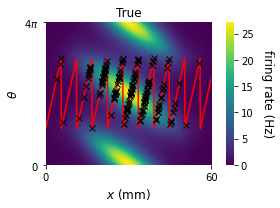

In [176]:
t_spikes_flatten = np.array([item for sublist in t_spikes[1:3] for item in sublist], dtype='int32')
heatmap_GP([], 60, x_t, theta_t+2*np.pi, t_spikes_flatten)

#### Example training for single constant speed

In [7]:
neurons = 1
sim_samples = 1000
n_runs = 20
x_max=60
dt = 1*1.5

x_ts, theta_ts, spikes, t_spikes = gen_toy_data(run_type='random_v',
                                                  dt=dt,
                                                  n_runs=n_runs,
                                                  neurons=neurons,
                                                  sim_samples=sim_samples)

# of spikes: 126967.0
# of timesteps: 20000
Average spike density: 6.34835


In [16]:
rate_model_2D = GP_2D(x_ts, theta_ts, spikes, n_runs, x_max, dt, neurons, sim_samples) #1*dt n=50

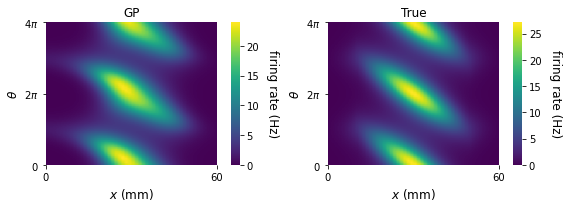

In [17]:
fig = heatmap_GP([rate_model_2D], 60) # 1*dt n=5
# fig.savefig('output/GP_2D_dt1_n5.svg', bbox_inches='tight')

In [18]:
rate_model_2x1D = GP_2x1D_prod(x_ts, theta_ts, spikes, n_runs, x_max, dt, neurons, sim_samples)


Stopped at epoch 446.


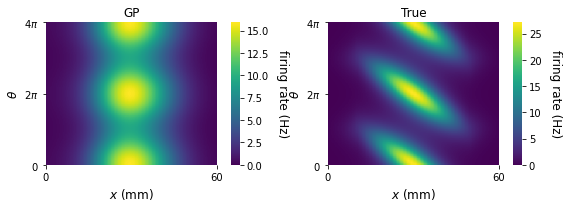

In [19]:
fig = heatmap_GP([rate_model_2x1D], 60) #1*dt n=5
# fig.savefig('output/GP_2x1D_dt1_n5.svg', bbox_inches='tight')

#### Comparing the type of runs

single_v
Dilation exceeded: False
Dilation: 12858
# of spikes: 39338.0
# of timesteps: 5000
Average spike density: 7.8676



Stopped at epoch 617.



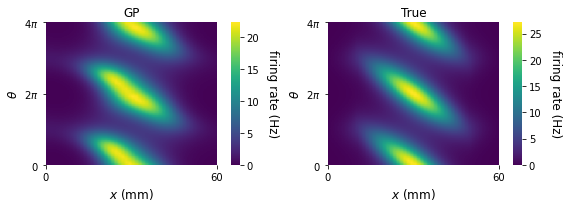


Stopped at epoch 233.



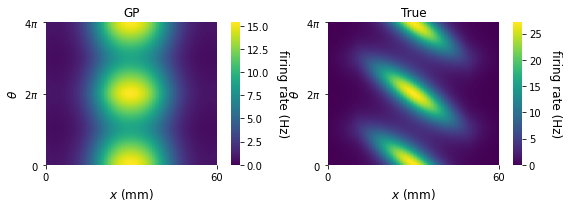

-----------------------------------
constant_v
Dilation exceeded: False
Dilation: 12889
# of spikes: 27369.0
# of timesteps: 5000
Average spike density: 5.4738



Stopped at epoch 378.



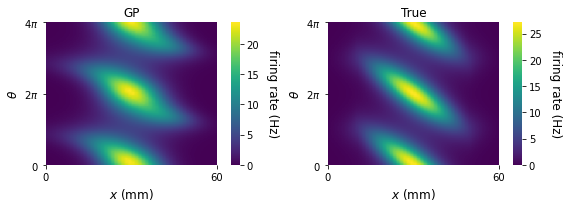


Stopped at epoch 394.



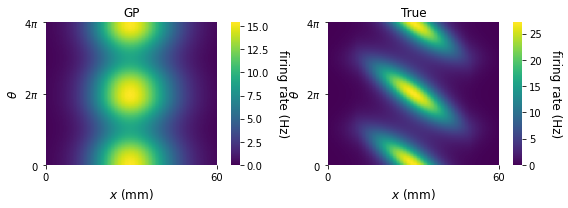

-----------------------------------
random_constant_v
Dilation exceeded: False
Dilation: 12848
# of spikes: 27343.0
# of timesteps: 5000
Average spike density: 5.4686



Stopped at epoch 409.



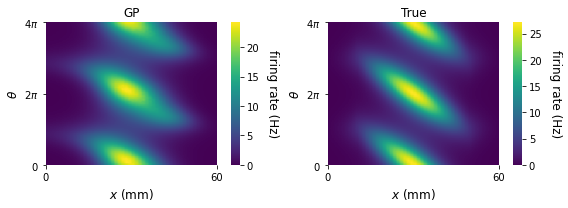


Stopped at epoch 265.



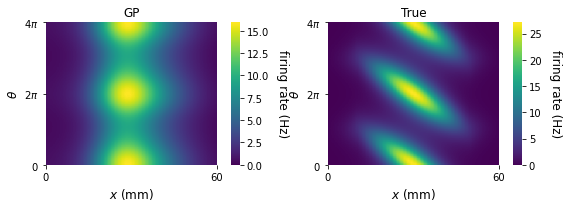

-----------------------------------
random_v
Dilation exceeded: False
Dilation: 12849
# of spikes: 27527.0
# of timesteps: 5000
Average spike density: 5.5054



Stopped at epoch 375.



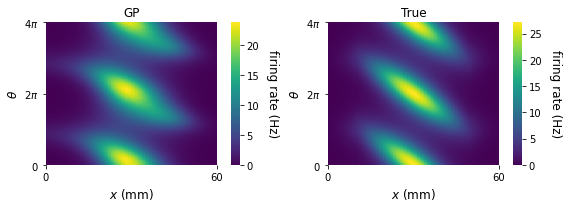


Stopped at epoch 441.



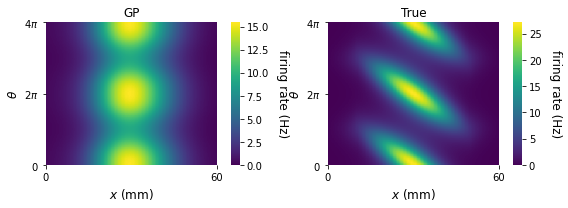

-----------------------------------


In [89]:
neurons = 1
sim_samples = 1000
n_runs = 5
x_max=60
dt = 1*1.5

run_types = ['single_v', 'constant_v', 'random_constant_v', 'random_v']

for rt in run_types:
    print(rt)
    # Generate data for run_type
    x_ts, theta_ts, spikes, t_spikes = gen_toy_data(run_type=rt,
                                                      dt=dt,
                                                      n_runs=n_runs,
                                                      neurons=neurons,
                                                      sim_samples=sim_samples)
    # Train 2D GP
    rate_model_2D = GP_2D(x_ts, theta_ts, spikes, n_runs, x_max, dt, neurons, sim_samples)
    fig = heatmap_GP([rate_model_2D], 60)

    # Train 2x1D GP
    rate_model_2x1D = GP_2x1D_prod(x_ts, theta_ts, spikes, n_runs, x_max, dt, neurons, sim_samples)
    fig = heatmap_GP([rate_model_2x1D], 60)
    print('-----------------------------------')

#### Validation

Given two rate models

In [113]:
rate_model_2D, rate_model_2x1D

In [150]:
# Generate random x, theta samples
n = int(1e3)
x_max = 60
x_val = np.random.rand(n) * x_max
theta_val = np.random.rand(n) * 2*np.pi
covariates = [x_val, tools.WrapPi(theta_val, True)]

# Then generate spikes from it
spikes, t_spikes = gen_spikes([x_val], [theta_val])

Dilation exceeded: False
Dilation: 12893
# of spikes: 78344.0
# of timesteps: 10000
Average spike density: 7.8344


In [151]:
# ML for rate model 2D

likelihood = mdl.likelihoods.Poisson(1, # number of neurons
                                       'exp') # inverse link function
likelihood.set_params(dt, jitter=1e-3) # set time bin and jitter (numerical stability)

glm_2D = mdl.inference.nll_optimized([rate_model_2D], likelihood)
glm_2D.preprocess(covariates, # input regressors of GP
               n, # number of timesteps in total
               spikes.reshape((1, n)), # spike trains
               #batch_size=[sim_samples]*len(dxs)) # separate batches, batch size (over timesteps)
               batch_size=n) # single batch, do all in parallel

nll_MC = glm_2D.nll(0, ll_mode='MC', ll_samples=100) # 100 MC samples
nll_GH = glm_2D.nll(0, ll_mode='GH', ll_samples=100) # 100 quadrature points
print("MC estimate per timestep: ", nll_MC / n)
print("GH estimate per timestep:", nll_GH / n)

MC estimate per timestep:  tensor(2.3136, grad_fn=<DivBackward0>)
GH estimate per timestep: tensor(2.3159, grad_fn=<DivBackward0>)


In [154]:
# ML for rate model 2x1D

likelihood = mdl.likelihoods.Poisson(1, # number of neurons
                                       'relu') # inverse link function (relu as individual GPs already exp)
likelihood.set_params(dt, jitter=1e-3) # set time bin and jitter (numerical stability)

glm_2x1D = mdl.inference.nll_optimized([rate_model_2x1D], likelihood)
glm_2x1D.preprocess(covariates, # input regressors of GP
               n, # number of timesteps in total
               spikes.reshape((1, n)), # spike trains
               #batch_size=[sim_samples]*len(dxs)) # separate batches, batch size (over timesteps)
               batch_size=n) # single batch, do all in parallel

nll_MC = glm_2x1D.nll(0, ll_mode='MC', ll_samples=100) # 100 MC samples
nll_GH = glm_2x1D.nll(0, ll_mode='GH', ll_samples=100) # 100 quadrature points
print("MC estimate: ", nll_MC / n)
print("GH estimate:", nll_GH / n)

MC estimate:  tensor(3.5210, grad_fn=<DivBackward0>)
GH estimate: tensor(3.5222, grad_fn=<DivBackward0>)
